# Game Prototype of Team Scotland #2
Felix Zaussinger, Martina Buck | 01.12.2020, 15:30

======================================================================================================================

                                            GAME CONFIGURATION

======================================================================================================================

**Magic commands**

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**External imports**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import configparser
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**Figure properties**

In [3]:
sns.set_context("poster")
sns.set(rc={'figure.figsize': (8, 5)})
sns.set_style("ticks")

**Directory structure**

In [4]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "plots")
project_dir

'/Users/felix/ETH/code/gecm'

**Append project directory to PYTHONPATH via sys (!)**

Source: https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

In [5]:
if project_dir not in sys.path:
    sys.path.append(project_dir)

#### import our own code from src

In [6]:
from src.gecm.game import MatrixGame
from src.gecm import model, vis, io, game, base, dicts
from src.gecm.dicts import (
        original_lulc_mapping,
        lulc_remapping,
        simplified_lulc_mapping,
        simplified_lulc_mapping_colors
    )

#### Game parameters

In [7]:
# size of playing field in pixels
n_pixels = 80

# complexity of playing field (only granularity = 1 works for now)
granularity = 1

# colormap
simplified_lulc_cm = ListedColormap(
    [simplified_lulc_mapping_colors[x] for x in simplified_lulc_mapping_colors.keys()]
)

# path to raster data file (must be a geotiff)
fpath_map = os.path.join(
    data_processed, "NFI_rasterized_{}_{}.tif".format(n_pixels, n_pixels)
)

#### Configuration file

In [8]:
# init config file parser. methods: config.getboolean, config.getint, ... .
config = configparser.ConfigParser()
fpath_cf = os.path.join(project_dir, 'config.ini')
config.read(fpath_cf)

# Show configuration file sections
io.config_describe(config)


--- default ---
credentials: 'google_api_credentials.json'
scopes: https://www.googleapis.com/auth/spreadsheets.readonly

--- gdrive_spreadsheet_ids ---
spreadsheet_id_farmers: 1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc
spreadsheet_id_foresters: 1ir8WkfKpyEGkamASbd0pf9IDAE74M4Q1fsHYl4r9F34
spreadsheet_id_tourism: 1fUVnVSacYUQYvZmjTJzqzob6vRmseA33EPcV3H26wDg
spreadsheet_id_model: 1CVdDndGD1S8ab3D1KlXYcBcnjK8sBPl68Eth0KMgaEQ

--- gdrive_sheet_names ---
sheet_names_farmers: Farmer_1, Farmer_2
sheet_names_foresters: Forester_1, Forester_2
sheet_names_tourism: SSDA
sheet_names_model: model_parameters, model_calculations


#### Google Drive Connection

In [9]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = [config.get(section="default", option="scopes")]

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

#### Conceptual model parameters & calculations

In [10]:
%reload_ext autoreload
model_settings_dict = io.parse_sheets(
        spreadsheet_id=config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_model"), 
        sheets=io.parse_list(config_string=config.get(section="gdrive_sheet_names", option="sheet_names_model")),
        credentials_fpath=credentials_fpath, 
        scopes=SCOPES,
        to_numeric=True
    )

# extract model_parameters as dictionary
model_parameters_dict = model_settings_dict["model_parameters"].loc[:, ["variable", "value"]].set_index("variable").to_dict()["value"]

# TODO: maybe delete
# add to local namespace, quick-fix based on: https://stackoverflow.com/questions/4357851/creating-or-assigning-variables-from-a-dictionary-in-python
# locals().update(model_parameters_dict)

# add model_parameters to config file
config['model_parameters'] = model_parameters_dict

# display contents of config file
# io.config_describe(config)

#### Playing field

In [11]:
%reload_ext autoreload
matrix_game = MatrixGame(
    fpath=fpath_map,
    original_lulc_mapping=original_lulc_mapping,
    simplified_lulc_mapping=simplified_lulc_mapping,
    lulc_remapping=lulc_remapping,
    model_param_dict=model_parameters_dict,
    config_file=config,
    credentials_fpath=credentials_fpath
)

# initialise playing field (crucial, else nothing works!)
matrix_game.initialise(granularity=1)

# sanity check on current round
assert matrix_game.current_round == 0

======================================================================================================================

                                            START OF ACTUAL GAME

======================================================================================================================

### Starting Point ("Round 0")

In [12]:
assert matrix_game.current_round == 0

####  Dashboard

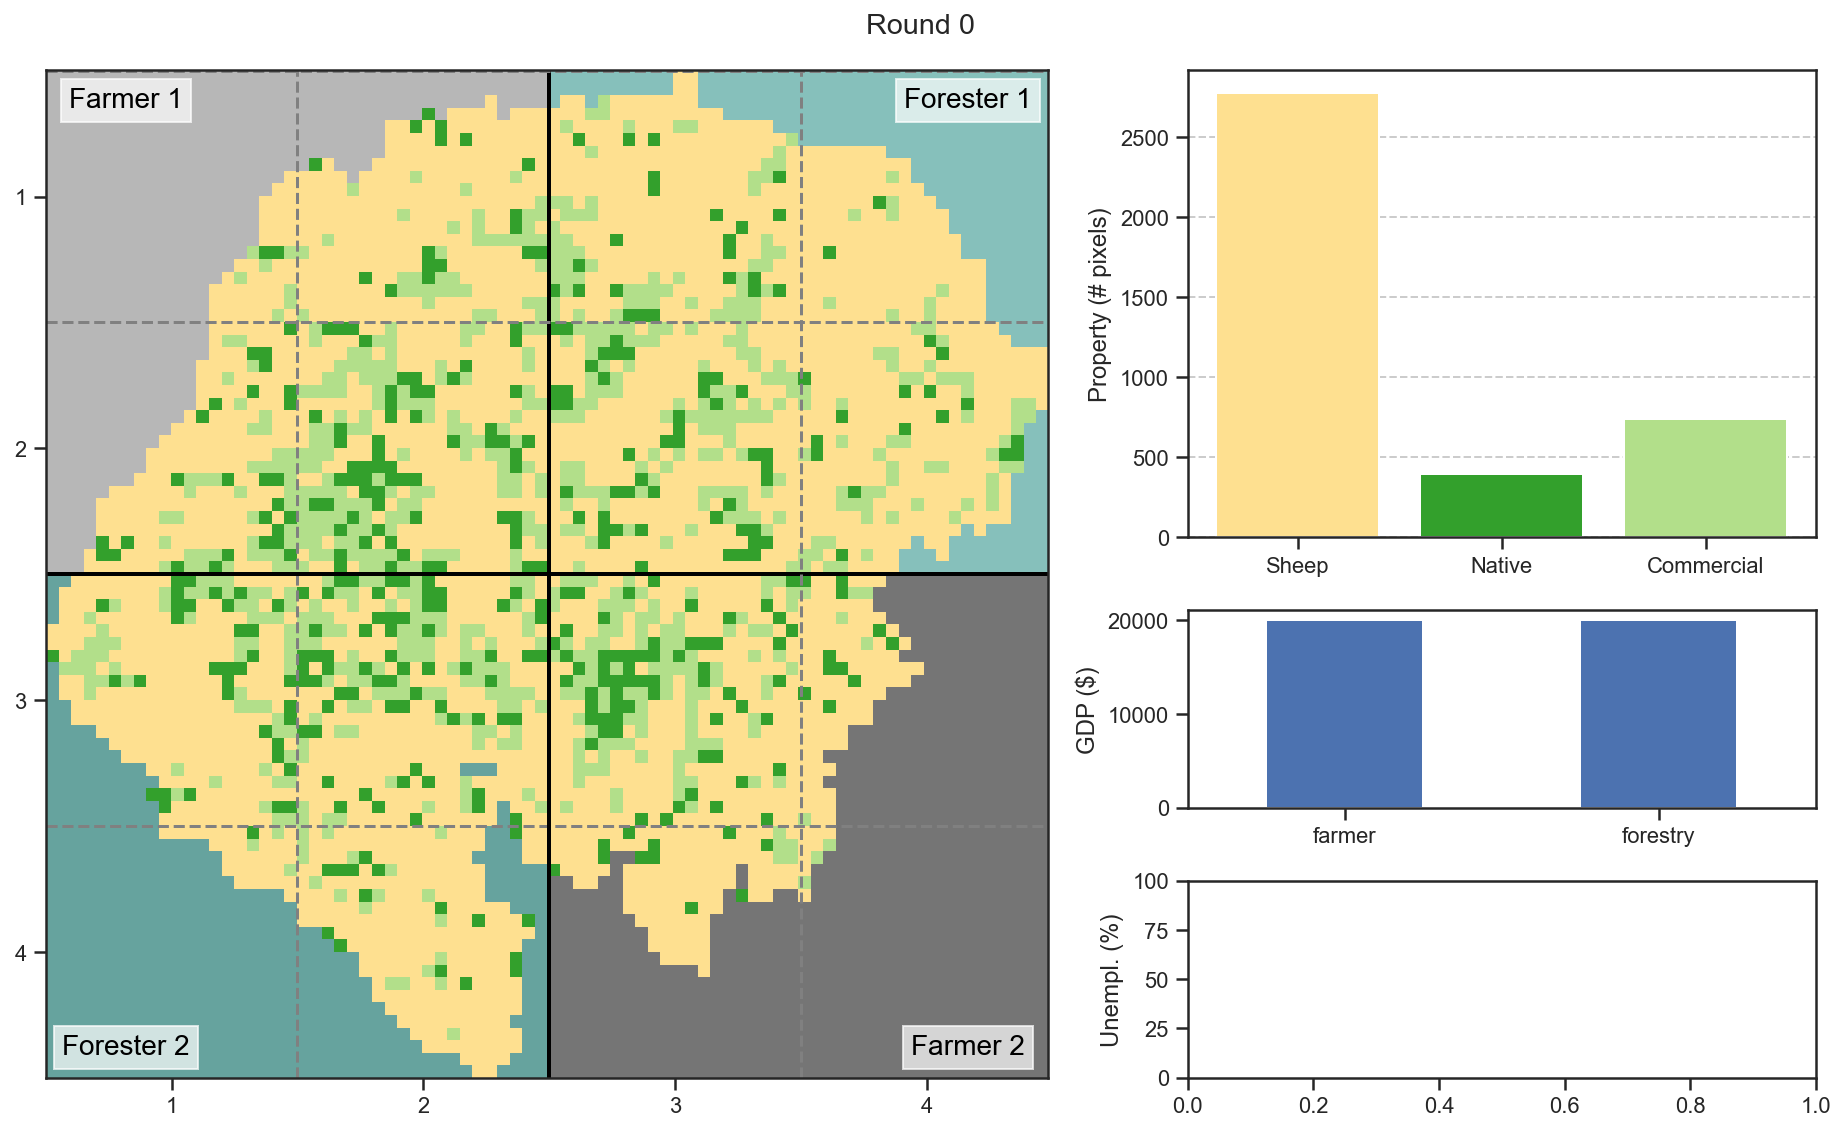

In [13]:
%reload_ext autoreload
matrix_game.show_dashboard(figure_size=(13,8), property_rights=True, cattle=False)

In [14]:
# assert 1 == 2

### Round 1

#### 0. Updating round number

In [15]:
matrix_game.update_round_number()
assert matrix_game.current_round == 1

#### 1. Downloading management decisions

Farmer_1
Farmer_2
Forester_1
Forester_2
SSDA
CPU times: user 1.92 s, sys: 304 ms, total: 2.22 s
Wall time: 7.88 s


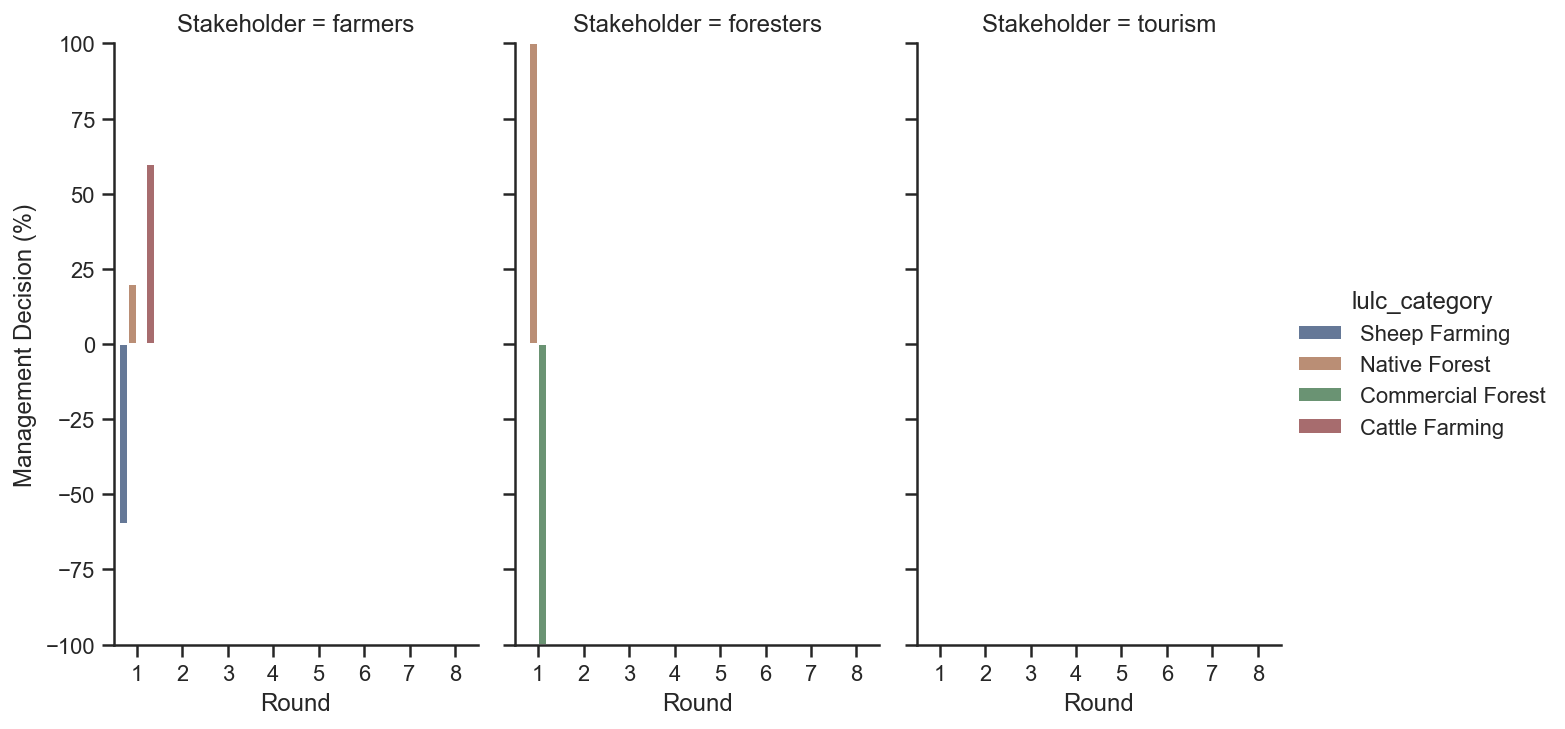

In [16]:
%%time
%reload_ext autoreload

# download mgmt decisions
matrix_game.fetch_mgmt_decisions()

# visualize
matrix_game.show_all_mgmt_decisions()

#### 2. Updating landscape

In [17]:
%reload_ext autoreload
# matrix_game.current_round = 1
matrix_game.update_lulc_matrix_based_on_mgmt_decisions(current_round=None)

Farmer_1
Farmer_1: farming type conversion
Farmer_1: converting between forest types
Forester_1
Forester_1: no farming type conversion
Forester_1: converting between forest types
Forester_2
Forester_2: no farming type conversion
Forester_2: converting between forest types
Farmer_2
Farmer_2: farming type conversion
Farmer_2: no conversion between forest types


#### 3. Calculating Income & Updating Bank Accounts

In [18]:
# TODO: MARTINA
locals().update(matrix_game.model_param_dict)
matrix_game.model_param_dict

{'income_farmland_sheep': 30,
 'income_farmland_cattle': 100,
 'income_forest_commercial': 200,
 'income_forest_native': 50,
 'gdp_tourism': 43952,
 'gdp_average': 29600,
 'income_farm': 39000,
 'unempl_rate_scotland': 5,
 'unempl_rate_scotland_west': 5,
 'bank_account_farmer_1': 10000,
 'bank_account_farmer_2': 10000,
 'bank_account_forestry_1': 10000,
 'bank_account_forestry_2': 10000,
 'uk_farmland_sheep': 20,
 'uk_farmland_cattle': 15,
 'cap_farmland_sheep': 60,
 'cap_farmland_cattle': 40,
 'use_farmer': 30000,
 'use_forester': 30000,
 'income_forest_commercial_brexit': 240,
 'income_forest_native_brexit': 60,
 'tax_below_survival30k': 0,
 'tax_till45k': 21,
 'tax_till150k': 41,
 'tax_above150k': 46}

#### Teamwork Boolean

In [19]:
# TODO: update matrix_game.cooperation_matrix_block_lvl based on mgtmt decisions
teamwork_bool = model.teamwork(matrix_game.cooperation_matrix_block_lvl)

#### Tourism factor

In [20]:
# make tourism choice
tourism_block_choice = 22
tourism_mask = matrix_game.block_definition_matrix_pixel_lvl == tourism_block_choice

# copy lulc_matrix data from stack
mar = matrix_game.lulc_matrix_stack[:, :, matrix_game.current_round - 1].copy()

# update the mask of the lulc_matrix based on the block mask
mar[~tourism_mask] = np.ma.masked

# calc
number_tourists, tourism_factor = model.tourism_factor(
    tourism_factor_matrix=mar,
    gdp_tourism_factor=40
)

# TODO: wie einbauen in visualisierung
number_tourists, tourism_factor

(4800.0, 0.75)

In [21]:
number_tourists

4800.0

#### Changes in prices

In [22]:
# round where brexit occurs
brexit = 3

# yield in round 0
_, tot_sheep, _, _ = model.yield_map(matrix_game.lulc_matrix_stack[:,:,0])

# yield in this round
tot_cattle, _, tot_n_forest, tot_c_forest = model.yield_map(matrix_game.lulc_matrix_stack[:,:,0])

# calculate prices
cattle_price_new, sheep_price_new, n_forest_price_new, c_forest_price_new = model.price_per_pixel(
    current_round=matrix_game.current_round,
    brexit=brexit,
    tot_sheep_0=tot_sheep,
    tot_cattle=tot_cattle,
    tot_n_forest=tot_n_forest,
    tot_c_forest=tot_c_forest,
    income_farmland_cattle=income_farmland_cattle,
    income_farmland_sheep=income_farmland_sheep,
    income_forest_native=income_forest_native,
    income_forest_commercial=income_forest_commercial
)

cattle_price_new, sheep_price_new, n_forest_price_new, c_forest_price_new

(100.0, 30, 55.55555555555556, 250.0)

#### Calculate incomes
In every round, we need to update income and bank accounts for all 4 stakeholders separately (!)

Data stores

In [23]:
# 4 player x 4 lulc types = 16 listen
# Runde 0: preise = income

# these areas refer to the aggregate property of each stakeholder
stakeholder_farmer1_data_dict = {
    "area_sheep": [120, 100],
    "area_cattle": [0, 0],
    "area_c_forest": [50, 50],
    "area_n_forest": [0, 20],
    "income": [gdp_average],  # to be updated after calculating money_farmer and money_forester (!)
    "bank_account": [10000],  # to be updated after calculating money_farmer and money_forester (!)
    "unemployment": [unempl_rate_scotland] # to be updated after calculating unemployment_rate after money_farmer and money_forester (!)
}

# TODO: init above and append price changes
price_data_dict = {
    "sheep_price": [income_farmland_sheep, sheep_price_new],
    "cattle_price": [income_farmland_cattle, cattle_price_new],
    "n_forest_price": [income_forest_commercial, n_forest_price_new],
    "c_forest_price": [income_forest_native, c_forest_price_new]
}

Farmers

In [24]:
%reload_ext autoreload
earning, bank_current = model.money_farmer(
    current_round=matrix_game.current_round,
    tourism_factor=tourism_factor,
    teams=1,  # fixed
    brexit=brexit,
    teamwork=teamwork_bool,
    area_sheep=stakeholder_farmer1_data_dict["area_sheep"],
    area_cattle=stakeholder_farmer1_data_dict["area_cattle"],
    area_c_forest=stakeholder_farmer1_data_dict["area_c_forest"],
    area_n_forest=stakeholder_farmer1_data_dict["area_n_forest"],
    sheep_price=price_data_dict["sheep_price"],
    cattle_price=price_data_dict["cattle_price"],
    n_forest_price=price_data_dict["n_forest_price"],
    c_forest_price=price_data_dict["c_forest_price"],
    bank_account_farmer_1=bank_account_farmer_1,  # farmers share same bank account in beginning
    bank=stakeholder_farmer1_data_dict["bank_account"][matrix_game.current_round - 1],  # needs to be subset as an integer
    gdp_pc_scotland=gdp_average,
)

# update data stores
stakeholder_farmer1_data_dict["income"].append(earning)
stakeholder_farmer1_data_dict["bank_account"].append(bank_current)

stakeholder_farmer1_data_dict

{'area_sheep': [120, 100],
 'area_cattle': [0, 0],
 'area_c_forest': [50, 50],
 'area_n_forest': [0, 20],
 'income': [29600, 11675.555555555555],
 'bank_account': [10000, -7924.444444444445],
 'unemployment': [5]}

Foresters

In [25]:
earning, bank_current = model.money_forester(
    current_round=matrix_game.current_round,
    tourism_factor=tourism_factor,
    teams=1,  # fixed
    brexit=brexit,
    teamwork=teamwork_bool,
    area_sheep=stakeholder_farmer1_data_dict["area_sheep"],
    area_c_forest=stakeholder_farmer1_data_dict["area_c_forest"],
    area_n_forest=stakeholder_farmer1_data_dict["area_n_forest"],
    sheep_price=price_data_dict["sheep_price"],
    n_forest_price=price_data_dict["n_forest_price"],
    c_forest_price=price_data_dict["c_forest_price"],
    bank_account_forestry_1=bank_account_farmer_1,  # farmers share same bank account in beginning
    bank=stakeholder_farmer1_data_dict["bank_account"][matrix_game.current_round - 1],  # needs to be subset as an integer
    gdp_pc_scotland=gdp_average,
)

earning, bank_current

(60119.12698412698, 40319.12698412698)

#### Unemployment rate

In [26]:
new_unemployment = model.unemployment_rate(
    earning=stakeholder_farmer1_data_dict["income"][matrix_game.current_round-1], 
    earning_new=stakeholder_farmer1_data_dict["income"][matrix_game.current_round], 
    unemployment=stakeholder_farmer1_data_dict["unemployment"][matrix_game.current_round-1]
)

# update data store
stakeholder_farmer1_data_dict["unemployment"].append(new_unemployment)

In [27]:
stakeholder_farmer1_data_dict

{'area_sheep': [120, 100],
 'area_cattle': [0, 0],
 'area_c_forest': [50, 50],
 'area_n_forest': [0, 20],
 'income': [29600, 11675.555555555555],
 'bank_account': [10000, -7924.444444444445],
 'unemployment': [5, 5.33641975308642]}

#### 4. Visualizing new dashboard

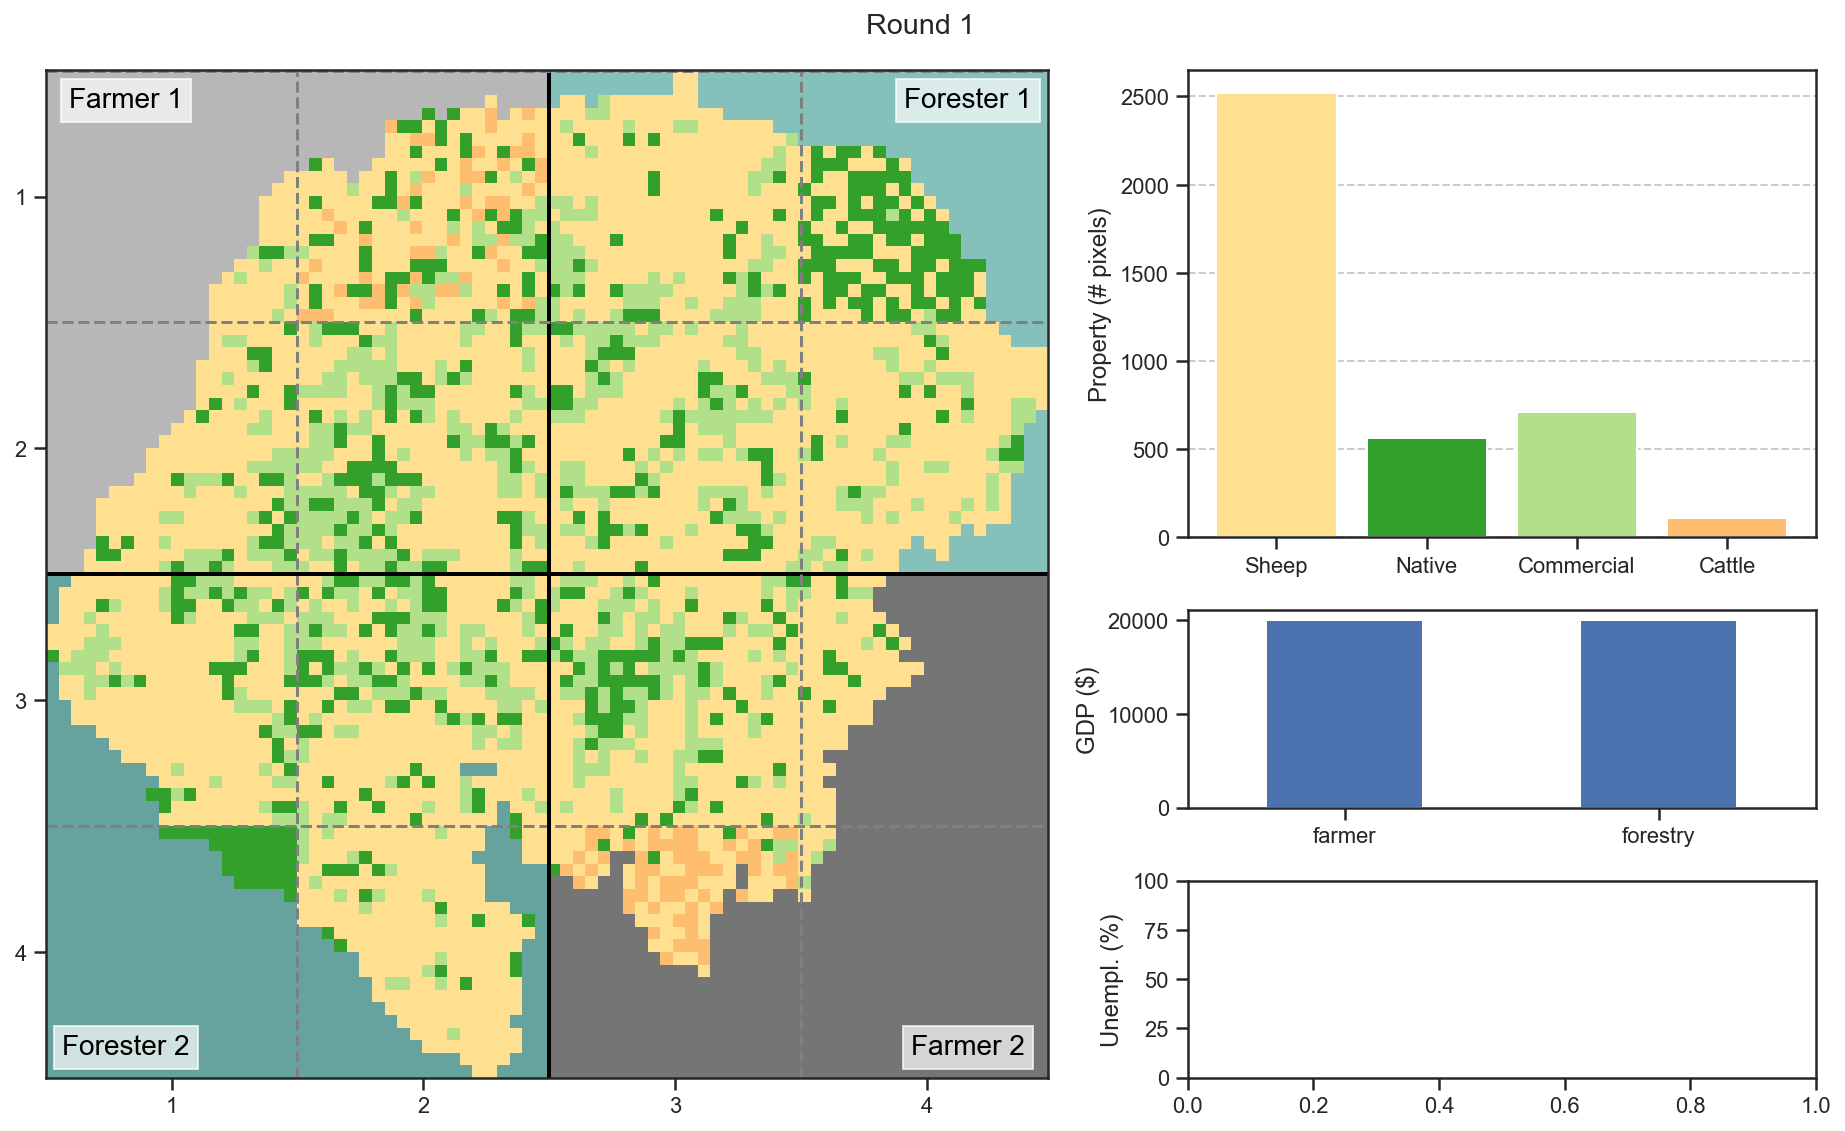

In [28]:
%reload_ext autoreload
matrix_game.current_round = 1
matrix_game.show_dashboard(figure_size=(13,8), property_rights=True, cattle=True)

## Round 2

#### 0. Updating round number

In [29]:
%reload_ext autoreload
matrix_game.update_round_number()
assert matrix_game.get_rounds(True) == 2

#### 1. Downloading management decisions

## Round 3